# LAB 1 (Andrea Mirenda s327644)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import tqdm.auto as tqdm

c:\Users\andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training a network on CIFAR10

### Dataset preparation

Con la funzione:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

Stiamo andando a creare un DataLoader e num_workers=2 IN GENERE LO PONGO PARI AL NUMERO DI CPU CHE ABBIAMO, IN GENERE LO FISSO A 2 O 4.

Ricorda che quando andiamo a trainare dobbiamo SEMPRE fare lo shuffle dei dati, ma quando TESTO NO!

In [ ]:
# Transformations to be applied to the output of the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Training dataset and dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Nota che :
num_workers=2 IN GENERE LO PONGO PARI AL NUMERO DI CPU CHE ABBIAMO, IN GENERE LO FISSO A 2 O 4

Notice that this is a very easy task since we already have the DataLoader with the corresponding method (len, getitem and init).

torch.Size([4, 3, 32, 32])
torch.Size([4])


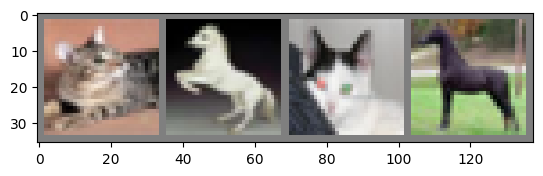

Labels: cat, horse, cat, horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)

# TODO: what's the content of images and labels?
# How are multiple images batched together
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print('Labels: ' + ', '.join(f'{classes[labels[j]].strip()}' for j in range(batch_size)))

Notice that, since the trainLoader, which is the DataLoader we created indicated 4 samples, t each iterations of the learning process we are providing to the network 4 distinct images.
Infact, the result of the function:

dataiter = iter(trainloader)

images, labels = next(dataiter)

is one that has as images 4 distinct images, so the shape of images will be [4,3,32,32], which means 4 images of shape [3,32,32]. And as labels the shape will be simply [4] and contains the categorical attributes related to each image.

## Network definition

Let's define a very basic neural network that takes an image as input and outputs one out of 10 labels.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#uso due Convolution layer e la softmax function.
class Net(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(n_classes=10)
#et = Net(n_classes=10).cuda(), cuda dice a torch che deve mettere tutti i parametri della rete sulla gpu.

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Notice that the last layer is fully connected and the number of output neurons is equal to the number of classes we want to classify.

Notice also that when we create the model we can specify whether we want it to be executed on the GPU or on the CPU. This choise is important since, depending on this, the data provided to the nutwork should be in the GPU (iput.cuda()) or in the cpu (by not specifing cuda).

In the code `self.conv1 = nn.Conv2d(3, 6, 5)`, you're defining a **convolutional layer** using PyTorch. The function `nn.Conv2d` creates a 2D convolution, commonly used in Convolutional Neural Networks (CNNs) for image processing. Let's break down the integer values you passed as arguments:

1. **3**: This represents the **number of input channels** of the image or tensor being passed to this layer. For example, if you're working with RGB images, there are 3 channels (Red, Green, Blue), so this value is set to 3.

2. **6**: This represents the **number of output channels**, i.e., the number of convolutional filters that will be applied to the image. In this case, you're creating 6 filters, each producing an output feature map. So, the result of this convolution will be a tensor with 6 channels.

3. **5**: This is the **kernel size**, which defines the size of the convolutional filter. In this case, the filter will be 5x5.

### In summary:
- **3**: Number of input channels (e.g., 3 for RGB images).
- **6**: Number of output channels (6 filters applied).
- **5**: Kernel size (5x5 filter).

So, you're applying a 2D convolution with 6 filters of size 5x5 to an image with 3 channels (like an RGB image).


## Optimizers

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


in genere lr sopratutto (momentum in genere non è così importante) lo devo scegliere con il validation set

## Training loop

Nota che se stai inserendo la rete dentro la gpu (hai creato la rete con cuda), devi mettere i dati in gpu, con il comando ".cuda()". Nota che infatti di default verrebbe messo tutto dentro la cpu creando errori visto che avremmo i dati in CPU e la rete in GPU.

Con la funzione zero_grad() stiamo andando ad azzerare il gradiente dei parametri per consentire di iniziare da zero.

Con la funzione backward calcoliamo il gradiente rispetto ai parametri e con step applichiamo la modifica ai parametri.

In [ ]:
for epoch in range(2):  # Loop over the dataset twice

    for i, (inputs, labels) in enumerate(trainloader):


        inputs, labels = inputs, labels
        #inputs.cuda e labels.cuda() serve sempre per andare a dire di mettere il parametro dentro la gpu

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward the input through the network
        logits = net(inputs)

        # Compute the loss value for the input
        loss = F.cross_entropy(logits, labels)

        # Compute gradients of the loss with respect to the model parameters
        loss.backward()
        #posso adesso esplorare il processo fatto da backward ocn il metodo

        # Apply gradient updates
        optimizer.step()

        if i % 1000 == 0:    # print every 2000 mini-batches
            print(f'Training loss: {loss.item():.3f}')


Training loss: 2.272
Training loss: 2.284
Training loss: 2.159
Training loss: 2.126
Training loss: 1.702
Training loss: 2.680
Training loss: 1.072
Training loss: 2.031
Training loss: 1.753
Training loss: 1.662
Training loss: 1.986
Training loss: 1.367
Training loss: 1.369
Training loss: 0.476
Training loss: 1.348
Training loss: 1.226
Training loss: 1.580
Training loss: 1.539
Training loss: 2.341
Training loss: 2.180
Training loss: 1.289
Training loss: 0.221
Training loss: 1.603
Training loss: 1.145
Training loss: 0.877
Training loss: 1.640


### BONUS: what happens after you call loss.backward()?

Try to inspect the `.grad` property of the network's parameters.

In [ ]:
inputs, labels = next(iter(trainloader))
inputs, labels = inputs, labels

# zero the parameter gradients
optimizer.zero_grad()

# Forward the input through the network
logits = net(inputs)

# Compute the loss value for the input
loss = F.cross_entropy(logits, labels)

# Compute the gradients
loss.backward()

net.parameters()

<generator object Module.parameters at 0x000001D23689F760>

## Validate the network on the test data

Con la funzione no_grad():
with torch.no_grad()
ti serve perché così dici di evitare di calcolare il gradiente quando devo effettuare validation, al fine di rendere più efficiente il codice.

Nota che la rete neurale è fata in modo da restituire tanti neuroni quante sono le classe che voglio classificare. Per ognuno di questi neuroni ti viene dato un valore tra zero e uno che indica la PROBABILITA' CHE UN SAMPLE SIA DI QUELLA CLASSE (a cui è associato il neurone in output).
Quindi per la predizione andiamo semplicemente a prendere il valore maggiore tra tutti i neuroni dell'ultimo livello.

In [ ]:
correct = 0
total = 0

with torch.no_grad():

    for inputs, labels in testloader:
        inputs, labels = inputs, labels

        # Compute the network logits for the input batch
        outputs = net(inputs)

        # For each input sample in the batch, we predict the class corresponding to the larget logit
        predicted_labels = outputs.max(1).indices
        #max(1) resitituisce l'indice del valore che minimizza la loss.

        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 57.06 %


57.06% is not that bad considering that we have 10 classes.

with torch.no_grad():
Questo mi serve per non memorizzare i gradient memories perché normalmente lo farebbe per darti maggiori informazioni.
Ma se non ti servono è meglio digliertelo per ottimizzarlo.

Quindi ricorda che quando usiamo i dati di training non specifichiamo no_grad perché poi vogliamo calcolare la loss, ma quando, invece, andiamo ad usare i dati di test, andiamo a calcolare il risultato della rete neurale specificando no_grad per fargli acapire che non ci servirà calcolare la loss quindi può ottimizzare delle operazioni.

## Extension to a new dataset

**It's your turn!**.

Download the Flowers dataset from http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat
!tar -xf 102flowers.tgz && rm 102flowers.tgz

"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
tar: Error opening archive: Failed to open '102flowers.tgz'


Flower dataset.

In [ ]:
import os.path as osp
from torch.utils.data import Dataset

from typing import Literal

from torchvision.io import read_image

from PIL import Image

import scipy.io


class FlowersDataset(Dataset):
    def __init__(self, split: Literal['trn', 'val', 'tst'],
                 labels_file: str, splits_path: str, img_dir: str, transform=None):
        self.split = split
        self.ids = np.array(scipy.io.loadmat('setid.mat')[f'{split}id']).squeeze()

        # Load the labels
        labels = np.array(scipy.io.loadmat('imagelabels.mat')['labels'].squeeze())
        self.labels = np.take(labels, self.ids, 0)

        self.img_dir = img_dir

        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image, label = None, None

        # TODO: ...

        return image, label

# My version of the getitem method

In [ ]:
def __getitem__(self, idx):
      # Ottieni l'ID dell'immagine
      img_id = self.ids[idx]

      # Costruisci il percorso dell'immagine
      img_path = osp.join(self.img_dir, f'image_{img_id:05d}.jpg')  # Formatta l'ID in modo che corrisponda al nome file

      # Carica l'immagine
      image = Image.open(img_path).convert('RGB')

      # Applica le trasformazioni, se definite
      if self.transform:
          image = self.transform(image)

      # Ottieni l'etichetta corrispondente
      label = self.labels[idx]

      return image, label

Problem: when i run the provided code with this method i obtain 15% accuracy.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(64),
    transforms.CenterCrop(64)
])

trainset = FlowersDataset("trn", "imagelabels.mat", "setid.mat", "jpg", transform=transform)
valset = FlowersDataset("val", "imagelabels.mat", "setid.mat", "jpg", transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


net = Net(n_classes=103)

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):  # Loop over the dataset twice

    for i, (inputs, labels) in enumerate(trainloader):

        inputs, labels = inputs, labels

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward the input through the network
        logits = net(inputs)

        # Compute the loss value for the input
        loss = F.cross_entropy(logits, labels)

        # Compute gradients of the loss with respect to the model parameters
        loss.backward()

        # Apply gradient updates
        optimizer.step()

        if i % 1000 == 0:    # print every 2000 mini-batches
            print(f'Training loss: {loss.item():.3f}')


In [ ]:
correct = 0
total = 0

with torch.no_grad():

    for inputs, labels in valloader:
        inputs, labels = inputs, labels

        # Compute the network logits for the input batch
        outputs = net(inputs)

        # For each input sample in the batch, we predict the class corresponding to the larget logit
        predicted_labels = outputs.max(1).indices

        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

### Potresti anbche scrivere: model.train(False) (invece di fare no_grad).

with torch.no_grad():
Questo mi serve per non memorizzare i gradient memories perché normalmente lo farebbe per darti maggiori informazioni.
Ma se non ti servono è meglio digliertelo per ottimizzarlo.